In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_hub as hub

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [ ]:
meta = pd.read_csv("/kaggle/input/deepfake-faces/metadata.csv")

In [ ]:
real_df = meta.loc[meta['label'] == "REAL",meta.columns]
real_df = real_df.drop(columns = ['original','original_width' ,'original_height','label'])
real_df.head(),real_df.shape

(         videoname
 17  mcehvkoidm.mp4
 26  wzrybcopcd.mp4
 30  tvrwjmjeyn.mp4
 47  gnrbhysdok.mp4
 68  gzmsocbmkz.mp4,
 (16293, 1))

In [ ]:
fake_df = meta.loc[meta['label'] == "FAKE",meta.columns]
fake_df = fake_df.drop(columns = ['original_width' ,'original_height','label'])
print(fake_df.shape)
fake_df = fake_df[fake_df['original'].isin(real_df['videoname'])]
fake_df.head(),fake_df.shape

(79341, 2)


(        videoname        original
 0  aznyksihgl.mp4  xnojggkrxt.mp4
 1  gkwmalrvcj.mp4  hqqmtxvbjj.mp4
 2  lxnqzocgaq.mp4  xjzkfqddyk.mp4
 3  itsbtrrelv.mp4  kqvepwqxfe.mp4
 4  ddvgrczjno.mp4  pluadmqqta.mp4,
 (75870, 2))

In [ ]:
real = real_df.sample(2500, random_state=22)
fake = fake_df.sample(2500, random_state=6)
real.shape,fake.shape

((2500, 1), (2500, 2))

In [ ]:
fake.head()

,videoname,original
70768,msnfesjjnu.mp4,crjvhcpwis.mp4
76545,rbltrwzhkp.mp4,zpykipigtu.mp4
83711,vgtggjgbez.mp4,sqzzafvbxy.mp4
47597,wrfrnandkk.mp4,srncaxcnfm.mp4
49006,ircmvzkosl.mp4,tlmhxzgnfc.mp4


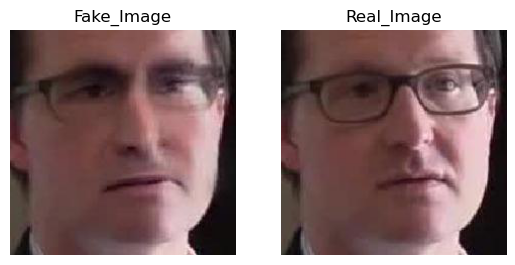

In [ ]:
fig,ax = plt.subplots(1,2)
def real_and_fake():
    index = random.randint(1,2499)
    fake_img = fake.iloc[index,0].replace(".mp4",'.jpg')
    real_img = fake.iloc[index,1].replace(".mp4",'.jpg')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title("Fake_Image")
    ax[1].set_title("Real_Image")
    ax[0].imshow(plt.imread("/kaggle/input/deepfake-faces/faces_224/"+fake_img))
    ax[1].imshow(plt.imread("/kaggle/input/deepfake-faces/faces_224/"+real_img))
real_and_fake()    

In [ ]:
real['original'] = real['videoname']
real.shape,fake.shape

((2500, 2), (2500, 2))

In [ ]:
def return_splits_ttv(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
    return train_data,test_data,val_data

def splits(real,fake):
    trainf,testf,valf = return_splits_ttv(fake)
    trainr,testr,valr = return_splits_ttv(real)
    train = pd.concat([trainf,trainr])
    test = pd.concat([testf,testr])
    val = pd.concat([valf,valr])
    return train,test,val

In [ ]:
train,test,val = splits(real,fake)

In [ ]:
print(train.shape)
print(test.shape)
print(val.shape)

(4000, 2)
(500, 2)
(500, 2)


In [ ]:
def rename_as_jpg(df):
    df['videoname'] = df['videoname'].str.replace(".mp4",".jpg")
    df['original'] = df['original'].str.replace(".mp4",".jpg")
    return df
train = rename_as_jpg(train)
test = rename_as_jpg(test)
val = rename_as_jpg(val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(train.shape)
print(test.shape)
print(val.shape)

(4000, 2)
(500, 2)
(500, 2)


In [ ]:
train

,videoname,original
19231,onrwqixejl.jpg,wwbvcyialw.jpg
38617,dftyisuemv.jpg,ljcjouvznz.jpg
2377,aafuphyhpt.jpg,uulplqqlom.jpg
25899,udxtaaipdt.jpg,urpdwjsjkf.jpg
58488,rgmyjcyejd.jpg,ouwbjprgsd.jpg
...,...,...
27902,gebpnpejld.jpg,gebpnpejld.jpg
35556,macyflayac.jpg,macyflayac.jpg
10483,ghdpzteruc.jpg,ghdpzteruc.jpg
46172,elzyaxzkbw.jpg,elzyaxzkbw.jpg


In [ ]:
def_path = "/kaggle/input/deepfake-faces/faces_224/"
def serialize_example(image_1,image_2,label):
    feature = {
               'image_1': tf.train.Feature(bytes_list = tf.train.BytesList(value = [image_1])),
               'image_2':tf.train.Feature(bytes_list = tf.train.BytesList(value = [image_2])),
               'label':tf.train.Feature(bytes_list = tf.train.BytesList(value = [label])),
               }

    feature = tf.train.Example(features = tf.train.Features(feature = feature))
    return feature.SerializeToString()
def write_records(df,path):
    with tf.io.TFRecordWriter(path,options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
        for img1,img2 in df.values:
            if img1 == img2:
                label = np.array(0,dtype = np.float32)
            else:
                label = np.array(1,dtype = np.float32)
            img1 = open(def_path+img1,'rb').read()
            img2 = open(def_path+img2,'rb').read()
            label = tf.io.serialize_tensor(label).numpy()
            example = serialize_example(img1,img2,label)
            writer.write(example)
            
write_records(train,"/kaggle/working/train_tf")  
write_records(test,"/kaggle/working/test_tf")  
write_records(val,"/kaggle/working/val_tf")  

In [ ]:
def parse_sample(example):
    feature = {'image_1':tf.io.FixedLenFeature([],tf.string),
              'image_2':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image_1 = tf.io.decode_jpeg(features['image_1'],channels = 3)
    image_1 = tf.image.resize(image_1,[256,256])
    image_2 = tf.io.decode_jpeg(features['image_2'],channels = 3)
    image_2 = tf.image.resize(image_2,[256,256])
   

    label = tf.io.parse_tensor(features['label'],out_type = tf.float32)
    label = tf.reshape(label,(1,))
    return {'image_1':image_1,},{'decoder_model':image_2,'siamese':label}

def read_dataset(ds):
    ds = tf.data.TFRecordDataset(ds,compression_type = "GZIP")
    ds = ds.map(parse_sample,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(600)
    ds = ds.batch(32,drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
train_ds = read_dataset("/kaggle/input/bestdeepfake/train_tf")
test_ds = read_dataset("/kaggle/input/bestdeepfake/test_tf")
val_ds = read_dataset("/kaggle/input/bestdeepfake/val_tf")

In [ ]:
test_ds

<PrefetchDataset element_spec=({'image_1': TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)}, {'decoder_model': TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), 'siamese': TensorSpec(shape=(32, 1), dtype=tf.float32, name=None)})>

In [ ]:
def print_random():
    fig,ax = plt.subplots(1,2)
    for x,y in test_ds.take(1):
        ax[0].imshow((x['image_1'].numpy()[10]).astype("uint8"))
        ax[1].imshow((y['decoder_model'].numpy()[10]).astype("uint8"))
        ax[0].axis('off')
        ax[1].axis('off')
        ax[0].set_title("Fake_Image")
        ax[1].set_title("Real_Image")
        if y['siamese'][10] == 1:
            print("Real and Fake Image")
        else:
            print("Both Real Image")

Real and Fake Image


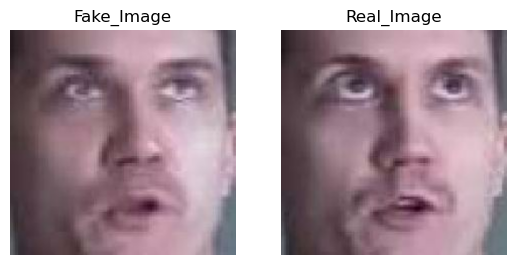

In [ ]:
print_random()

Both Real Image


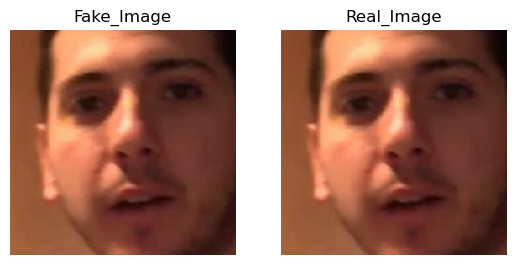

In [ ]:
print_random()

In [ ]:
class SQD(tf.keras.layers.Layer):
    def __init__(self):
        super(SQD, self).__init__()

    def call(self, inputs):
        x, y = inputs
        diff = tf.subtract(x, y)
        return tf.square(diff)
    


In [ ]:
diff_model = tf.keras.models.load_model("/kaggle/input/facenet/keras-facenet/model/facenet_keras.h5")

In [ ]:
def siamese(input_1,input_2,return_model = False):
    diff_model.load_weights("/kaggle/input/facenet/keras-facenet/weights/facenet_keras_weights.h5")
    for layer in diff_model.layers: 
        layer.trainable = False    
        
    ip_1 = tf.keras.Input(batch_size = 32,shape = input_1.shape[1:])
    ip_2 = tf.keras.Input(batch_size = 32,shape = input_2.shape[1:])
    
    op1 = tf.keras.layers.Resizing(160,160)(ip_1)
    op2 = tf.keras.layers.Resizing(160,160)(ip_2)
    
    op1 = diff_model(op1)
    op2 = diff_model(op2)
    
    output = tf.keras.layers.concatenate([op1,op2])
    output = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'label')(output)
    
    model = tf.keras.Model(inputs = [ip_1,ip_2],outputs = output,name = 'siamese')
    if return_model:
        return model
    return model([input_1,input_2],training = True)

In [ ]:
import gc
class free_mem(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
cb = [free_mem(),
     tf.keras.callbacks.EarlyStopping(monitor = 'val_siamese_accuracy',patience = 2)]        

In [ ]:
encoder = hub.KerasLayer('https://kaggle.com/models/emilutz/vgg19-unpooling-encoder-decoder/frameworks/TensorFlow2/variations/vgg19-block1-conv2-unpooling-encoder/versions/1') # external model
decoder = hub.KerasLayer('https://kaggle.com/models/emilutz/vgg19-unpooling-encoder-decoder/frameworks/TensorFlow2/variations/vgg19-block1-conv2-unpooling-decoder/versions/1') # this model

In [ ]:
def resnet(inputs,filters,return_model = False):
    input_tensor = tf.keras.Input(batch_size = 32,shape = inputs.shape[1:])
    output = tf.keras.layers.SeparableConv2D(filters = filters,kernel_size = (3,3),padding = 'same')(input_tensor)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Activation('relu')(output)
    output = tf.keras.layers.SeparableConv2D(filters = filters,kernel_size = (3,3),padding = 'same')(output)
    output = tf.keras.layers.BatchNormalization()(output)
    
    model = tf.keras.Model(inputs = [input_tensor],outputs = output)
    if return_model:
        return model
    return model(inputs,training = True)

In [ ]:
class cast_layer(tf.keras.layers.Layer):
    def __init__(self,name):
        super(cast_layer, self).__init__()
        self._name = name
    def call(self, inputs):
        return tf.cast(inputs,tf.float32)
    
    
def autoencoder():
    inputs = tf.keras.Input(batch_size = 32,shape = (256,256,3),name = 'image_1')
    outputs = encoder(inputs)
    outputs = resnet(outputs,64)
    outputs = resnet(outputs,64)
    outputs = resnet(outputs,64)
    outputs = decoder(outputs)
    output_1 = cast_layer(name = 'decoder_model')(outputs)
    output_2 = siamese(inputs,output_1)
    return tf.keras.Model(inputs = inputs,outputs = {'decoder_model':output_1,
                                                     'siamese':output_2
                                                     })
model = autoencoder()

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1 (InputLayer)           [(32, 256, 256, 3)]  0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (32, 256, 256, 64)   38720       ['image_1[0][0]']                
                                                                                                  
 model (Functional)             (32, 256, 256, 64)   9984        ['keras_layer[0][0]']            
                                                                                                  
 model_1 (Functional)           (32, 256, 256, 64)   9984        ['model[0][0]']                  
                                                                                            

In [ ]:
model.compile(optimizer = 'adam',
             loss = {
                 'siamese':'binary_crossentropy',
                 'decoder_model':'mae'
             },
             metrics = {
                 'siamese':'accuracy',
                 'decoder_model':'mae'
             }
             )

In [ ]:
model.fit(train_ds,epochs = 10,validation_data = val_ds,callbacks = cb)

Epoch 1/10
125/125 [==============================] - 117s 673ms/step - loss: 10.7352 - decoder_model_loss: 10.2554 - siamese_loss: 0.4798 - decoder_model_mae: 10.2554 - siamese_accuracy: 0.8665 - val_loss: 11.8112 - val_decoder_model_loss: 11.3245 - val_siamese_loss: 0.4867 - val_decoder_model_mae: 11.3245 - val_siamese_accuracy: 0.8058
Epoch 2/10
125/125 [==============================] - 94s 655ms/step - loss: 10.6023 - decoder_model_loss: 10.2175 - siamese_loss: 0.3848 - decoder_model_mae: 10.2175 - siamese_accuracy: 0.8714 - val_loss: 11.8023 - val_decoder_model_loss: 11.3271 - val_siamese_loss: 0.4752 - val_decoder_model_mae: 11.3271 - val_siamese_accuracy: 0.8289
Epoch 3/10
125/125 [==============================] - 94s 653ms/step - loss: 10.6620 - decoder_model_loss: 10.2303 - siamese_loss: 0.4317 - decoder_model_mae: 10.2303 - siamese_accuracy: 0.8701 - val_loss: 11.9136 - val_decoder_model_loss: 11.3301 - val_siamese_loss: 0.5835 - val_decoder_model_mae: 11.3301 - val_siamese

In [ ]:
model.save("best_till_now.h5")

In [ ]:
def binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,70,255,0)
    return thresh

In [ ]:
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.load_model("/kaggle/input/bestdeepfake/best_till_now.h5",
                                    custom_objects = {
                                        'KerasLayer':hub.KerasLayer,
                                        'SQD':tf.keras.layers.Layer,
                                        'cast_layer':tf.keras.layers.Layer
                                    })

In [ ]:
def print_predictions():
    fig,ax = plt.subplots(2,3)
    for x,y in test_ds.take(1):
        img0 = (x['image_1'].numpy()[10])
        img1 = (y['decoder_model'].numpy()[10])
        ax[0][0].imshow(binary(img0.astype("uint8")))
        ax[0][1].imshow(binary(img1.astype("uint8")))
        img2 = tf.squeeze(model(tf.expand_dims(img0,axis = 0))['decoder_model'])
        ax[0][2].imshow(binary(tf.cast(img2,tf.uint8).numpy()))
        
        ax[1][0].imshow(img0.astype("uint8"))
        ax[1][1].imshow((img1.astype("uint8")))
        ax[1][2].imshow((tf.cast(img2,tf.uint8).numpy()))
        
        ax[0][0].axis('off')
        ax[0][1].axis('off')
        ax[0][2].axis('off')
           
        if y['siamese'][10] == 1:
            ax[0][0].set_title("Fake_Image")
            ax[0][1].set_title("Real_Image")
            ax[0][2].set_title("Produced_Real_Image")
        else:
            ax[0][0].set_title("Real_Image")
            ax[0][1].set_title("Real_Image")
            ax[0][2].set_title("Produced_Real_Image")
            

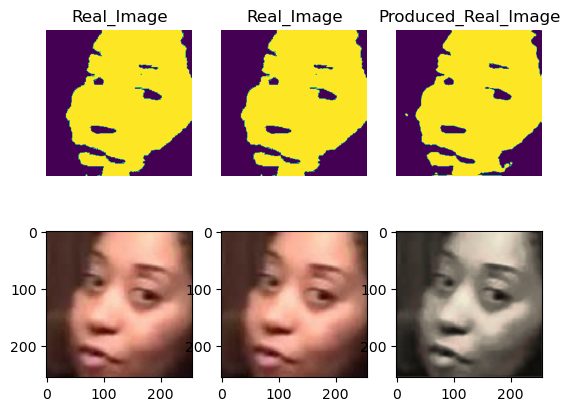

In [ ]:
print_predictions()